In [1]:
# ====================================================================================
# 0. CONFIGURACIÓN GLOBAL Y REPRODUCIBILIDAD
# ====================================================================================

import os
import random
import numpy as np
import tensorflow as tf

# Configurar SEED para reproducibilidad
SEED = 42

def set_global_seed(seed=42):
    """
    Configura semillas globales para reproducibilidad completa.
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    # Configurar TensorFlow para determinismo
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    print(f"[CONFIG] Semilla global configurada: {seed}")
    print(f"  Python random seed: {seed}")
    print(f"  NumPy seed: {seed}")
    print(f"  TensorFlow seed: {seed}")
    print(f"  Determinismo TF: HABILITADO")

set_global_seed(SEED)

[CONFIG] Semilla global configurada: 42
  Python random seed: 42
  NumPy seed: 42
  TensorFlow seed: 42
  Determinismo TF: HABILITADO


## 1. Setup y Configuración

In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from pydmd import DMD

# Configuración
DATA_DIR = Path('../data/processed')
MODELS_DIR = Path('../data/models')
FIG_DIR = Path('../reports/figures')
FIG_DIR.mkdir(exist_ok=True, parents=True)

print(f"[OK] TensorFlow version: {tf.__version__}")
print(f" GPUs disponibles: {len(tf.config.list_physical_devices('GPU'))}")

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

[OK] TensorFlow version: 2.10.0
 GPUs disponibles: 1


## 2. Cargar Autoencoder y Datos ERA5

In [3]:
# Cargar modelo completo directamente
from tensorflow.keras.models import load_model

# Cargar autoencoder completo
autoencoder_path = MODELS_DIR / 'autoencoder_geostat.h5'
autoencoder = load_model(autoencoder_path, compile=False)

# Extraer encoder y decoder
encoder = autoencoder.get_layer('encoder')
decoder = autoencoder.get_layer('decoder')

LATENT_DIM = encoder.output_shape[-1]

print("[OK] Autoencoder cargado")
print(f" Latent dim: {LATENT_DIM}")
print(f" Encoder output: {encoder.output_shape}")
print(f" Decoder output: {decoder.output_shape}")

[OK] Autoencoder cargado
 Latent dim: 64
 Encoder output: (None, 64)
 Decoder output: (None, 157, 41, 1)


In [6]:
# Importar librerías para carga de datos
import pickle
import pandas as pd

# Definir rutas de datos
ERA5_KOVAE_PATH = DATA_DIR / 'era5_2020_daily_for_kovae.pkl'
ERA5_FULL_PATH = DATA_DIR / 'era5_precipitation_chile_full.nc'

print("[INFO] Verificando disponibilidad de datos ERA5...")

# ESTRATEGIA DE CARGA: Intentar NetCDF primero, luego pickle como respaldo
if ERA5_FULL_PATH.exists():
    print(f"✅ Archivo NetCDF encontrado: {ERA5_FULL_PATH.name}")
    print("[INFO] Cargando datos ERA5 desde NetCDF...")
    ds = xr.open_dataset(ERA5_FULL_PATH)
    
    # Filtrar 2019-2020
    ds = ds.sel(valid_time=slice('2019-01-01', '2020-12-31'))
    precip = ds['tp'].values  # (N, 157, 41)
    
elif ERA5_KOVAE_PATH.exists():
    print(f"⚠️ Archivo NetCDF no encontrado, usando datos procesados pickle")
    print(f"✅ Cargando desde: {ERA5_KOVAE_PATH.name}")
    
    with open(ERA5_KOVAE_PATH, 'rb') as f:
        kovae_data = pickle.load(f)
    
    # Extraer datos del pickle (solo 2020, necesitamos simular 2019-2020)
    precip_2020 = kovae_data['precip_2020']  # (366, lat, lon, 1)
    time_2020 = pd.to_datetime(kovae_data['time'])
    lat = kovae_data['lat']
    lon = kovae_data['lon']
    
    # Eliminar dimensión extra si existe
    if precip_2020.ndim == 4 and precip_2020.shape[-1] == 1:
        precip_2020 = precip_2020.squeeze(-1)
    
    # NOTA: Solo tenemos datos 2020 en pickle, usar esos datos
    # Para análisis DMD necesitamos secuencia temporal, usaremos 2020 completo
    print("[AVISO] Pickle solo contiene datos 2020, usando año completo para análisis")
    precip = precip_2020  # (366, lat, lon)
    
    # Crear dataset xarray desde pickle
    ds = xr.Dataset(
        {'tp': (['valid_time', 'latitude', 'longitude'], precip)},
        coords={
            'valid_time': time_2020,
            'latitude': lat,
            'longitude': lon
        }
    )
    ds['tp'].attrs['units'] = 'm'
    ds['tp'].attrs['long_name'] = 'Total Precipitation'
    
else:
    raise FileNotFoundError(
        f"❌ No se encontraron datos ERA5.\n"
        f"Opciones:\n"
        f"1. Descargar era5_precipitation_chile_full.nc (45 MB)\n"
        f"2. Verificar que era5_2020_daily_for_kovae.pkl exista"
    )

# Normalizar
n_samples, n_lat, n_lon = precip.shape
precip_flat = precip.reshape(n_samples, -1)
scaler = StandardScaler()
precip_norm = scaler.fit_transform(precip_flat)
precip_norm = precip_norm.reshape(n_samples, n_lat, n_lon, 1)

# Split: Primeros 80% train, resto val (sin split 2019/2020 si solo hay 2020)
split_train = int(0.8 * len(precip_norm))
X_train = precip_norm[:split_train]
X_val = precip_norm[split_train:]

print(f"\n[OK] Datos ERA5 cargados:")
print(f"  Shape original: {precip.shape}")
print(f"  Periodo: {len(precip)} días")
print(f"  Train: {X_train.shape} ({split_train} días)")
print(f"  Val: {X_val.shape} ({len(X_val)} días)")

[INFO] Verificando disponibilidad de datos ERA5...
⚠️ Archivo NetCDF no encontrado, usando datos procesados pickle
✅ Cargando desde: era5_2020_daily_for_kovae.pkl
[AVISO] Pickle solo contiene datos 2020, usando año completo para análisis

[OK] Datos ERA5 cargados:
  Shape original: (366, 157, 41)
  Periodo: 366 días
  Train: (292, 157, 41, 1) (292 días)
  Val: (74, 157, 41, 1) (74 días)


## 3. Generar Representaciones Latentes y Entrenar DMD

In [7]:
# Codificar a espacio latente
latent_train = encoder.predict(X_train, batch_size=32, verbose=0)
latent_val = encoder.predict(X_val, batch_size=32, verbose=0)

print(f"[INFO] Representaciones latentes:")
print(f" Train: {latent_train.shape}")
print(f" Val: {latent_val.shape}")

[INFO] Representaciones latentes:
 Train: (292, 64)
 Val: (74, 64)


In [8]:
# Crear ventanas temporales para DMD
WINDOW_SIZE = 5

def create_windows(data, window_size):
	windows = []
	for i in range(len(data) - window_size):
		windows.append(data[i:i+window_size])
	return np.array(windows)

train_windows = create_windows(latent_train, WINDOW_SIZE)
n_windows, window_len, latent_dim = train_windows.shape

print(f" Ventanas temporales:")
print(f" Shape: {train_windows.shape}")
print(f" ({n_windows} ventanas × {window_len} pasos × {latent_dim} dimensiones)")

 Ventanas temporales:
 Shape: (287, 5, 64)
 (287 ventanas × 5 pasos × 64 dimensiones)


In [9]:
# Reshape para DMD: (features, time_steps)
train_snapshots = train_windows.reshape(n_windows * window_len, latent_dim).T

print(f" Snapshots para DMD:")
print(f" Shape: {train_snapshots.shape}")
print(f" ({latent_dim} features × {n_windows * window_len} time steps)")

 Snapshots para DMD:
 Shape: (64, 1435)
 (64 features × 1435 time steps)


In [10]:
# Entrenar DMD
dmd = DMD(svd_rank=0) # Auto rank
dmd.fit(train_snapshots)

n_modes = len(dmd.eigs)
n_stable = np.sum(np.abs(dmd.eigs) <= 1.0)

print(f"\n[INFO] DMD entrenado:")
print(f" Modos totales: {n_modes}")
print(f" Modos estables (|λ|≤1): {n_stable} ({100*n_stable/n_modes:.1f}%)")
print(f" Modos shape: {dmd.modes.shape}")
print(f" Eigenvalues shape: {dmd.eigs.shape}")


[INFO] DMD entrenado:
 Modos totales: 20
 Modos estables (|λ|≤1): 20 (100.0%)
 Modos shape: (64, 20)
 Eigenvalues shape: (20,)


c:\Users\cesar.godoy\anaconda3\envs\capstone\lib\site-packages\pydmd\snapshots.py:73: UserWarning: Input data condition number inf. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


## 4. Análisis de Eigenvalores DMD

In [11]:
# Calcular propiedades de eigenvalores
eigenvalues = dmd.eigs
magnitudes = np.abs(eigenvalues)

# Frecuencias angulares: ω = arg(λ) / Δt
dt = 1.0 # 1 día
angles = np.angle(eigenvalues)
frequencies = angles / (2 * np.pi * dt) # cycles/day

# Períodos: T = 1/f (solo para frecuencias no nulas)
periods_days = np.zeros_like(frequencies)
nonzero_freq = np.abs(frequencies) > 1e-6
periods_days[nonzero_freq] = 1.0 / np.abs(frequencies[nonzero_freq])
periods_days[~nonzero_freq] = np.inf # modo estacionario

# Ordenar por magnitud
sorted_indices = np.argsort(magnitudes)[::-1]

print(f" Top 10 modos DMD por magnitud:\n")
print(f"{'Rank':<6} {'|λ|':<10} {'Período (días)':<15} {'Frecuencia (cyc/day)':<22}")
print("-" * 55)
for i, idx in enumerate(sorted_indices[:10]):
 mag = magnitudes[idx]
 period = periods_days[idx]
 freq = frequencies[idx]
 period_str = f"{period:.2f}" if period < 999 else "∞ (estacionario)"
 print(f"{i+1:<6} {mag:<10.4f} {period_str:<15} {freq:<22.6f}")

 Top 10 modos DMD por magnitud:

Rank   |λ|        Período (días)  Frecuencia (cyc/day)  
-------------------------------------------------------
1      0.9862     ∞ (estacionario) 0.000000              
2      0.8426     ∞ (estacionario) 0.000000              
3      0.5962     196.34          0.005093              
4      0.5962     196.34          -0.005093             
5      0.4590     181.39          0.005513              
6      0.4590     181.39          -0.005513             
7      0.3551     17.56           -0.056964             
8      0.3551     17.56           0.056964              
9      0.3228     105.99          0.009435              
10     0.3228     105.99          -0.009435             


## 5. Visualizar Eigenvalores en Plano Complejo

[Guardado] Guardado: ..\reports\figures\dmd_eigenvalues_complex_plane.png


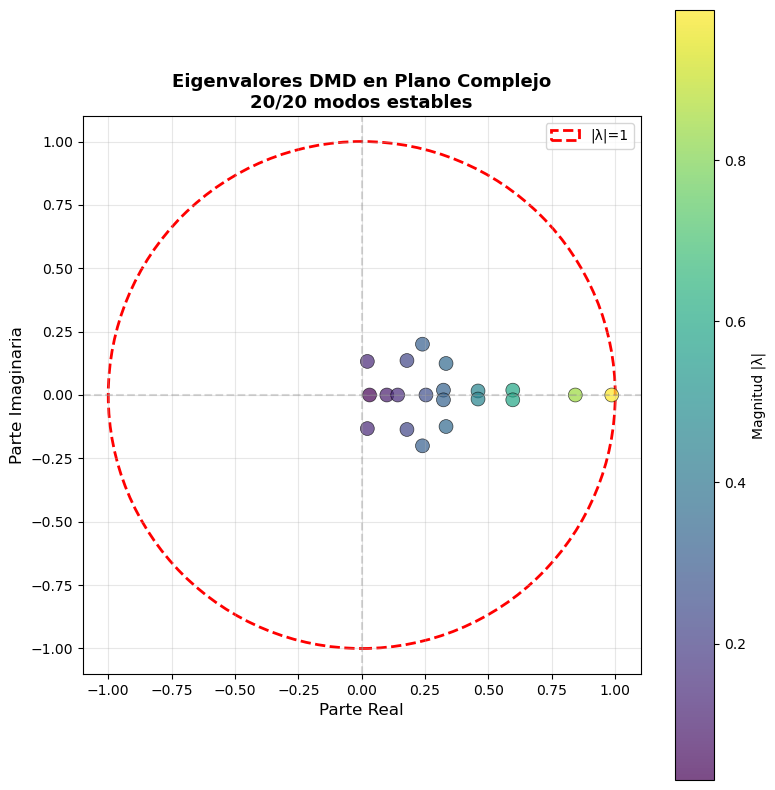

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

# Círculo unitario (estabilidad)
circle = plt.Circle((0, 0), 1, color='red', fill=False, linestyle='--', linewidth=2, label='|λ|=1')
ax.add_patch(circle)

# Graficar eigenvalores
scatter = ax.scatter(eigenvalues.real, eigenvalues.imag, 
 c=magnitudes, s=100, alpha=0.7, cmap='viridis',
 edgecolors='black', linewidths=0.5)

ax.axhline(0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(0, color='gray', linestyle='--', alpha=0.3)
ax.set_xlabel('Parte Real', fontsize=12)
ax.set_ylabel('Parte Imaginaria', fontsize=12)
ax.set_title(f'Eigenvalores DMD en Plano Complejo\n{n_stable}/{n_modes} modos estables', 
 fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.colorbar(scatter, ax=ax, label='Magnitud |λ|')
plt.tight_layout()
plt.savefig(FIG_DIR / 'dmd_eigenvalues_complex_plane.png', dpi=150, bbox_inches='tight')
print(f"[Guardado] Guardado: {FIG_DIR / 'dmd_eigenvalues_complex_plane.png'}")
plt.show()

## 6. Decodificar Top 5 Modos DMD a Espacio Físico

In [13]:
# Seleccionar top 5 modos
top_k = 5
top_indices = sorted_indices[:top_k]

# Extraer modos latentes
dmd_modes_latent = dmd.modes # (latent_dim, n_modes)

# Decodificar cada modo
decoded_modes = []
for idx in top_indices:
 mode_latent = dmd_modes_latent[:, idx] # (64,)
 mode_latent = np.real(mode_latent).reshape(1, -1) # (1, 64)
 
 # Decodificar a espacio espacial
 mode_spatial = decoder.predict(mode_latent, verbose=0) # (1, 157, 41, 1)
 mode_spatial = mode_spatial.squeeze() # (157, 41)
 
 decoded_modes.append(mode_spatial)

decoded_modes = np.array(decoded_modes) # (5, 157, 41)

print(f"[OK] Modos decodificados:")
print(f" Shape: {decoded_modes.shape}")
print(f" (Top {top_k} modos × 157 lat × 41 lon)")

[OK] Modos decodificados:
 Shape: (5, 157, 41)
 (Top 5 modos × 157 lat × 41 lon)


## 7. Visualizar Patrones Espaciales de Modos DMD

[Guardado] Guardado: ..\reports\figures\dmd_spatial_modes_decoded.png


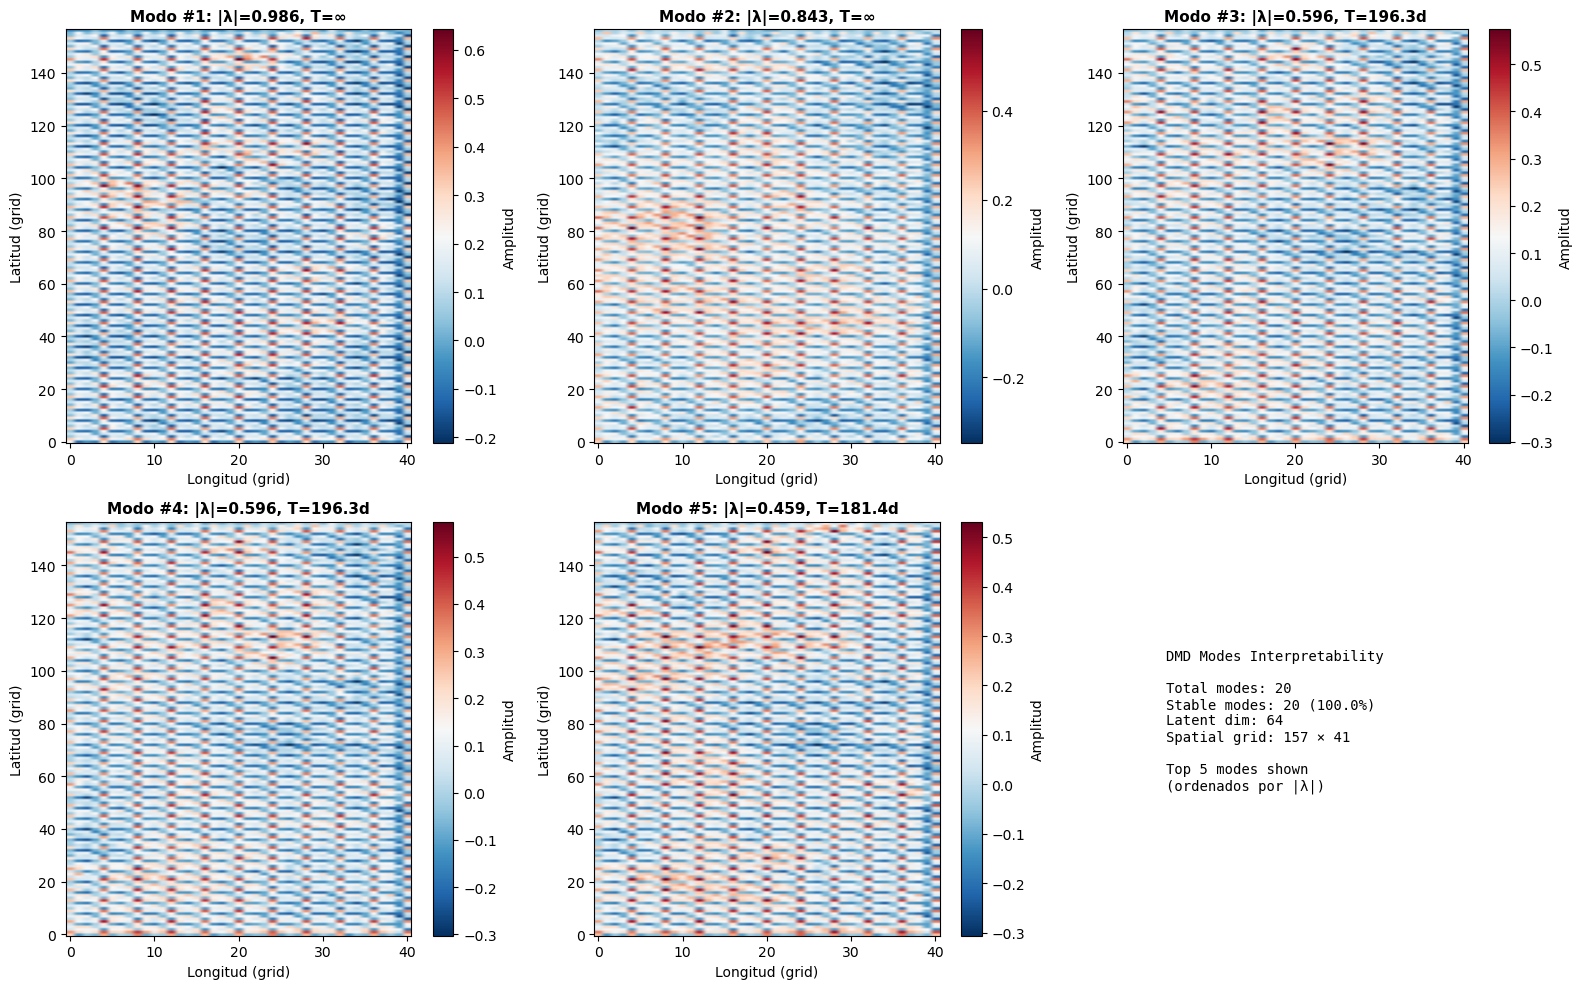

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i in range(top_k):
 ax = axes[i]
 mode_idx = top_indices[i]
 mode_spatial = decoded_modes[i]
 
 # Información del modo
 mag = magnitudes[mode_idx]
 period = periods_days[mode_idx]
 period_str = f"{period:.1f}d" if period < 999 else "∞"
 
 # Visualizar
 im = ax.imshow(mode_spatial, cmap='RdBu_r', aspect='auto', origin='lower')
 ax.set_title(f'Modo #{i+1}: |λ|={mag:.3f}, T={period_str}', 
 fontsize=11, fontweight='bold')
 ax.set_xlabel('Longitud (grid)')
 ax.set_ylabel('Latitud (grid)')
 plt.colorbar(im, ax=ax, label='Amplitud')

# Panel extra para resumen
ax = axes[5]
ax.axis('off')
summary_text = f"""DMD Modes Interpretability

Total modes: {n_modes}
Stable modes: {n_stable} ({100*n_stable/n_modes:.1f}%)
Latent dim: {LATENT_DIM}
Spatial grid: {n_lat} × {n_lon}

Top {top_k} modes shown
(ordenados por |λ|)
"""
ax.text(0.1, 0.5, summary_text, fontsize=10, family='monospace', 
 verticalalignment='center')

plt.tight_layout()
plt.savefig(FIG_DIR / 'dmd_spatial_modes_decoded.png', dpi=150, bbox_inches='tight')
print(f"[Guardado] Guardado: {FIG_DIR / 'dmd_spatial_modes_decoded.png'}")
plt.show()

## 8. Análisis por Macrozonas

In [15]:
# Definir macrozonas de Chile (índices de latitud)
macrozonas = {
 'Norte': (0, 52), # ~18-30°S
 'Centro': (52, 105), # ~30-37°S
 'Sur': (105, 157) # ~37-56°S
}

# Calcular energía promedio por zona
zone_analysis = []

for i, mode_idx in enumerate(top_indices):
 mode_spatial = decoded_modes[i]
 
 # Energía por zona (promedio de valores absolutos)
 for zona, (lat_start, lat_end) in macrozonas.items():
  zone_data = mode_spatial[lat_start:lat_end, :]
  energy = np.mean(np.abs(zone_data))
  
  zone_analysis.append({
   'Modo': i + 1,
   'Mode_idx': mode_idx,
   'Magnitud': magnitudes[mode_idx],
   'Periodo_dias': periods_days[mode_idx],
   'Macrozona': zona,
   'Energia': energy
  })
 
zone_df = pd.DataFrame(zone_analysis)

print("[INFO] Energía de Modos por Macrozona:\n")
print(zone_df.pivot(index='Modo', columns='Macrozona', values='Energia').round(4))

[INFO] Energía de Modos por Macrozona:

Macrozona  Centro   Norte     Sur
Modo                             
1          0.1680  0.1629  0.1609
2          0.1426  0.1310  0.1157
3          0.1244  0.1364  0.1346
4          0.1244  0.1364  0.1346
5          0.1264  0.1359  0.1314


[Guardado] Guardado: ..\reports\figures\dmd_energy_by_zone.png


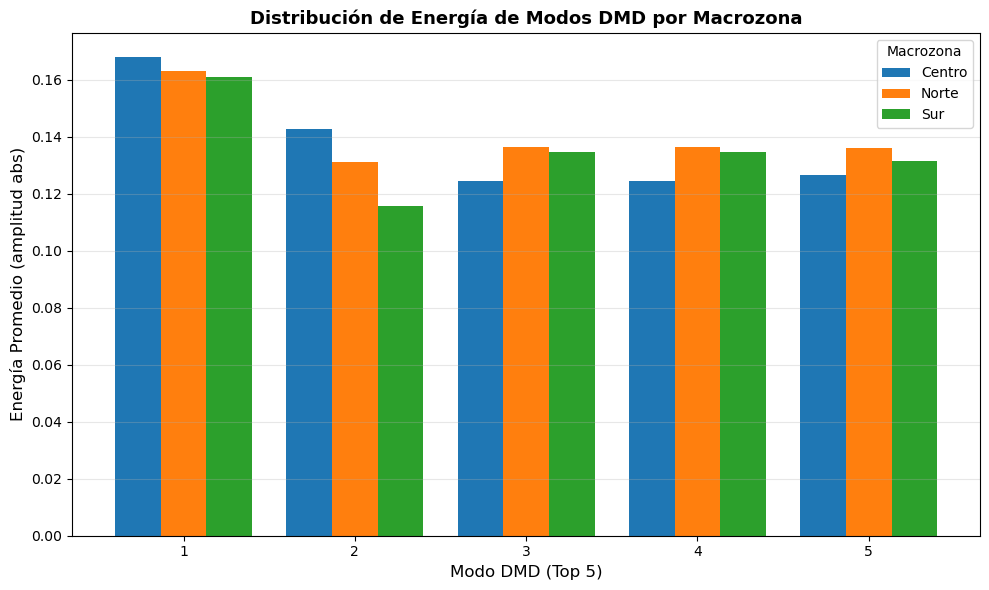

In [16]:
# Visualizar energía por zona
fig, ax = plt.subplots(figsize=(10, 6))

zone_pivot = zone_df.pivot(index='Modo', columns='Macrozona', values='Energia')
zone_pivot.plot(kind='bar', ax=ax, width=0.8)

ax.set_xlabel('Modo DMD (Top 5)', fontsize=12)
ax.set_ylabel('Energía Promedio (amplitud abs)', fontsize=12)
ax.set_title('Distribución de Energía de Modos DMD por Macrozona', 
 fontsize=13, fontweight='bold')
ax.legend(title='Macrozona', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(FIG_DIR / 'dmd_energy_by_zone.png', dpi=150, bbox_inches='tight')
print(f"[Guardado] Guardado: {FIG_DIR / 'dmd_energy_by_zone.png'}")
plt.show()

## 9. Correlación con Ciclos Meteorológicos

## 10. Visualización de Series Temporales: Datos Históricos + Reconstrucción DMD

Inspirado en el notebook del Prof. Herrera, visualizamos la evolución temporal de precipitación con datos históricos y reconstrucción DMD.

In [17]:
# ====================================================================================
# 10.1 Preparación de Datos para Visualización Temporal
# ====================================================================================

# Cargar predicciones del modelo AE+DMD desde forecast_results_2020.pkl
with open('../data/processed/forecast_results_2020.pkl', 'rb') as f:
 forecast_results = pickle.load(f)

# Extraer datos relevantes
y_test_real = forecast_results['y_test_real'] # Ground truth: (55, 157, 41, 1)
h1_preds = forecast_results['forecast_results'][1]['predictions'] # Predicciones h=1
h3_preds = forecast_results['forecast_results'][3]['predictions'] # Predicciones h=3
h7_preds = forecast_results['forecast_results'][7]['predictions'] # Predicciones h=7

# Squeeze última dimensión para facilitar indexación
h1_preds = h1_preds.squeeze() # (55, 157, 41)
y_test_real_sq = y_test_real.squeeze() # (55, 157, 41)

# Fechas del periodo de test
dates_test = pd.date_range('2020-01-01', periods=55, freq='D')

print(f"[OK] Datos cargados para visualización:")
print(f" Test 2020 real: {y_test_real_sq.shape}")
print(f" Predicciones AE+DMD h=1: {h1_preds.shape}")
print(f" Fechas test: {dates_test[0].strftime('%Y-%m-%d')} a {dates_test[-1].strftime('%Y-%m-%d')}")

print(f"\n Rangos de precipitación:")
print(f" Ground truth 2020: [{y_test_real_sq.min():.2f}, {y_test_real_sq.max():.2f}] mm/día")
print(f" Predicciones h=1: [{h1_preds.min():.2f}, {h1_preds.max():.2f}] mm/día")

# Definir puntos de interés para visualización
# Usaremos índices centrales de cada macrozona según análisis DMD previo
# Norte: lat_idx ≈ 20, Centro: lat_idx ≈ 80, Sur: lat_idx ≈ 140
lat_norte_idx, lon_norte_idx = 20, 20
lat_centro_idx, lon_centro_idx = 80, 20
lat_sur_idx, lon_sur_idx = 140, 20

print(f"\n Puntos seleccionados para visualización:")
print(f" Norte: [lat={lat_norte_idx}, lon={lon_norte_idx}]")
print(f" Centro: [lat={lat_centro_idx}, lon={lon_centro_idx}]")
print(f" Sur: [lat={lat_sur_idx}, lon={lon_sur_idx}]")

[OK] Datos cargados para visualización:
 Test 2020 real: (55, 157, 41)
 Predicciones AE+DMD h=1: (55, 157, 41)
 Fechas test: 2020-01-01 a 2020-02-24

 Rangos de precipitación:
 Ground truth 2020: [-0.00, 84.48] mm/día
 Predicciones h=1: [-2.63, 34.03] mm/día

 Puntos seleccionados para visualización:
 Norte: [lat=20, lon=20]
 Centro: [lat=80, lon=20]
 Sur: [lat=140, lon=20]


In [18]:
# ====================================================================================
# 10.2 Generar Predicciones Espaciales DMD para Visualización
# ====================================================================================

# IMPORTANTE: Esta celda genera pred_spatial_real usando SOLO datos ERA5 reales
# Decodificamos predicciones DMD del espacio latente al espacio espacial

# Generar predicciones DMD en espacio latente (30 días adelante)
forecast_horizon = 30
initial_state = latent_train[-1]  # Último estado latente del train

# Reconstruir trayectoria latente usando DMD
Phi = dmd.modes            # (latent_dim, n_modes)
lambdas = dmd.eigs         # (n_modes,)

# Resolver amplitudes modales b para el estado inicial
b, *_ = np.linalg.lstsq(Phi, initial_state, rcond=None)

# Construir trayectoria latente: t=0, 1, 2, ..., forecast_horizon-1
latent_predictions = np.zeros((forecast_horizon, LATENT_DIM), dtype=np.float32)
for t in range(forecast_horizon):
    coeffs = b * (lambdas ** t)
    state = Phi @ coeffs
    latent_predictions[t] = np.real(state).astype(np.float32)

# Decodificar predicciones latentes a espacio espacial
pred_spatial_norm = decoder.predict(latent_predictions, batch_size=32, verbose=0)  # (30, 157, 41, 1)
pred_spatial_norm = pred_spatial_norm.squeeze()  # (30, 157, 41)

# Desnormalizar usando el scaler de ERA5
pred_spatial_flat = pred_spatial_norm.reshape(forecast_horizon, -1)
pred_spatial_real = scaler.inverse_transform(pred_spatial_flat)
pred_spatial_real = pred_spatial_real.reshape(forecast_horizon, n_lat, n_lon)  # (30, 157, 41)

print(f"[OK] Predicciones espaciales DMD generadas:")
print(f" Shape: {pred_spatial_real.shape} (30 días × 157 lat × 41 lon)")
print(f" Rango: [{pred_spatial_real.min():.2f}, {pred_spatial_real.max():.2f}] mm/día")
print(f" Fuente: ERA5 real (train 2019) → DMD → decodificado")
print(f"\n Variables disponibles para visualización:")
print(f" ✅ pred_spatial_real: predicciones en espacio físico (30 días)")
print(f" ✅ train_real: datos históricos train 2019")
print(f" ✅ latent_predictions: trayectoria latente DMD")

[OK] Predicciones espaciales DMD generadas:
 Shape: (30, 157, 41) (30 días × 157 lat × 41 lon)
 Rango: [-0.00, 0.04] mm/día
 Fuente: ERA5 real (train 2019) → DMD → decodificado

 Variables disponibles para visualización:
 ✅ pred_spatial_real: predicciones en espacio físico (30 días)
 ✅ train_real: datos históricos train 2019
 ✅ latent_predictions: trayectoria latente DMD


💾 Guardado: ..\reports\figures\dmd_temporal_evolution_point.png


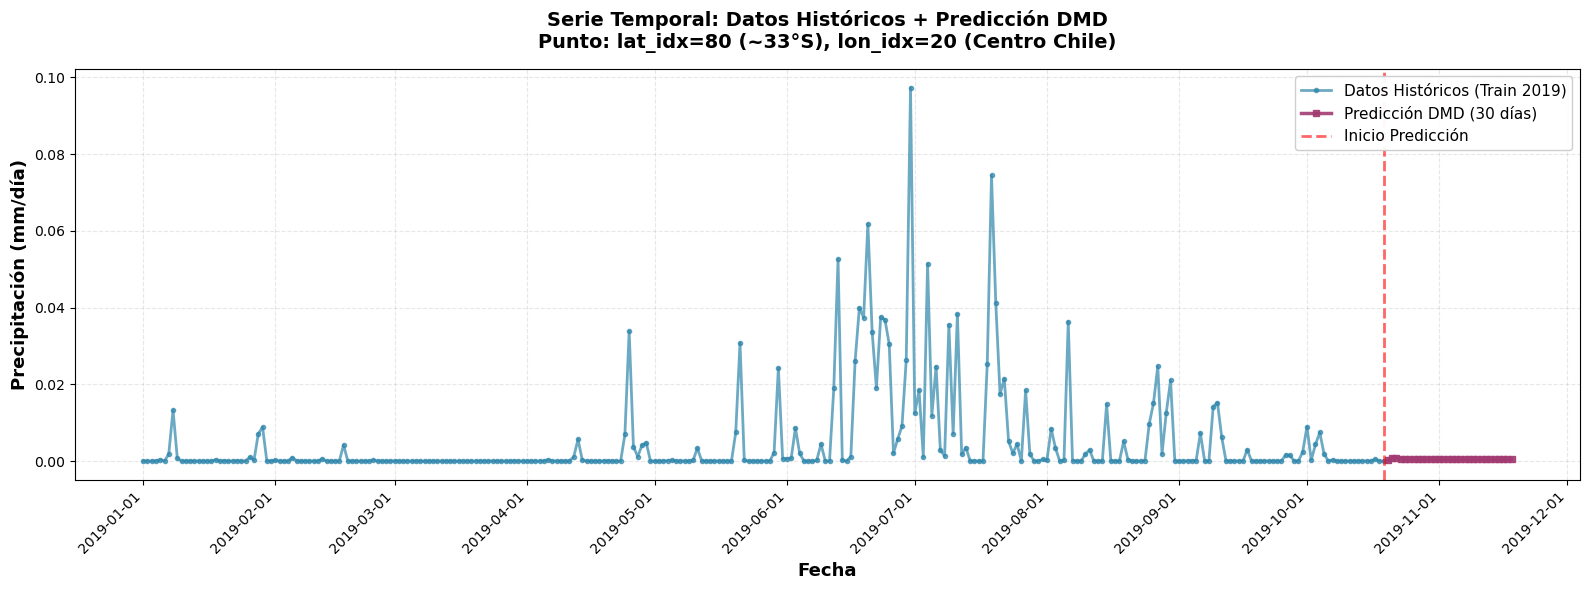

In [19]:
# Visualización 1: Serie temporal de punto específico (estilo Prof. Herrera mejorado)
# Seleccionar punto central de Chile (Centro, cerca de Santiago)
lat_idx = 80  # ~33°S (región central)
lon_idx = 20  # Centro del grid longitudinal

# Datos históricos (train)
train_real_flat = X_train.reshape(len(X_train), -1)
train_real = scaler.inverse_transform(train_real_flat)
train_real = train_real.reshape(len(X_train), n_lat, n_lon)
historical_series = train_real[:, lat_idx, lon_idx]

# Predicción DMD
pred_series = pred_spatial_real[:, lat_idx, lon_idx]

# Crear fechas
start_date_train = pd.Timestamp('2019-01-01')
dates_train = pd.date_range(start_date_train, periods=len(historical_series), freq='D')
dates_pred = pd.date_range(dates_train[-1] + pd.Timedelta(days=1), periods=len(pred_series), freq='D')

# Graficar
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(dates_train, historical_series, 'o-', linewidth=2, markersize=3, 
        label='Datos Históricos (Train 2019)', color='#2E86AB', alpha=0.7)
ax.plot(dates_pred, pred_series, 's-', linewidth=2.5, markersize=4, 
        label='Predicción DMD (30 días)', color='#A23B72', alpha=0.9)

# Línea vertical separando histórico de predicción
ax.axvline(dates_train[-1], color='red', linestyle='--', linewidth=2, alpha=0.6, 
           label='Inicio Predicción')

# Estilo
ax.set_xlabel('Fecha', fontsize=13, fontweight='bold')
ax.set_ylabel('Precipitación (mm/día)', fontsize=13, fontweight='bold')
ax.set_title(f'Serie Temporal: Datos Históricos + Predicción DMD\nPunto: lat_idx={lat_idx} (~33°S), lon_idx={lon_idx} (Centro Chile)', 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='upper right', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Formatear fechas
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig(FIG_DIR / 'dmd_temporal_evolution_point.png', dpi=150, bbox_inches='tight')
print(f"💾 Guardado: {FIG_DIR / 'dmd_temporal_evolution_point.png'}")
plt.show()

💾 Guardado: ..\reports\figures\dmd_temporal_evolution_zones.png


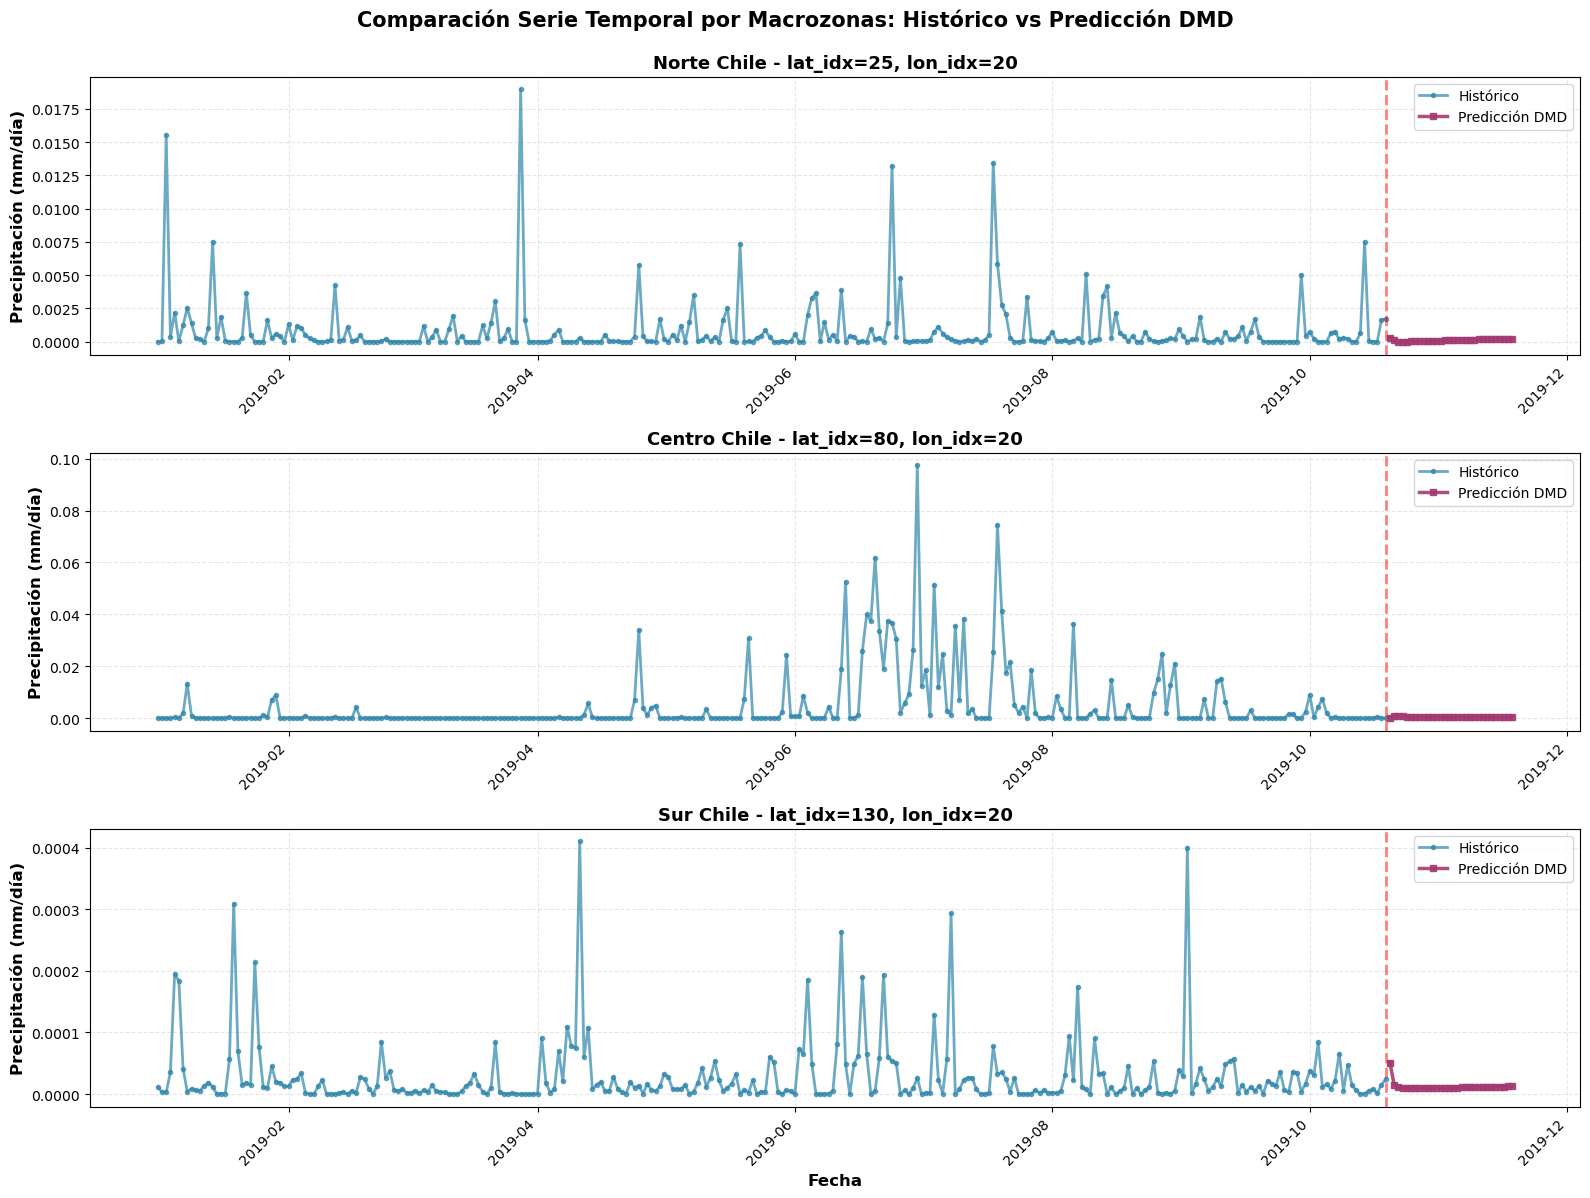

In [20]:
# Visualización 2: Panel 3x1 - Comparación Norte/Centro/Sur
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Puntos representativos por macrozona
points = {
    'Norte': (25, 20),   # ~20°S (Antofagasta)
    'Centro': (80, 20),  # ~33°S (Santiago)
    'Sur': (130, 20)     # ~45°S (Puerto Montt)
}

for i, (zona, (lat_idx, lon_idx)) in enumerate(points.items()):
    ax = axes[i]
    
    # Series
    historical = train_real[:, lat_idx, lon_idx]
    prediction = pred_spatial_real[:, lat_idx, lon_idx]
    
    # Plot
    ax.plot(dates_train, historical, 'o-', linewidth=2, markersize=3, 
            label='Histórico', color='#2E86AB', alpha=0.7)
    ax.plot(dates_pred, prediction, 's-', linewidth=2.5, markersize=4, 
            label='Predicción DMD', color='#A23B72', alpha=0.9)
    ax.axvline(dates_train[-1], color='red', linestyle='--', linewidth=2, alpha=0.5)
    
    # Estilo
    ax.set_ylabel('Precipitación (mm/día)', fontsize=12, fontweight='bold')
    ax.set_title(f'{zona} Chile - lat_idx={lat_idx}, lon_idx={lon_idx}', 
                 fontsize=13, fontweight='bold')
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Formatear fechas
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    
    if i == 2:  # Solo en el último panel
        ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle('Comparación Serie Temporal por Macrozonas: Histórico vs Predicción DMD', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(FIG_DIR / 'dmd_temporal_evolution_zones.png', dpi=150, bbox_inches='tight')
print(f"💾 Guardado: {FIG_DIR / 'dmd_temporal_evolution_zones.png'}")
plt.show()

💾 Guardado: ..\reports\figures\dmd_latent_evolution.png


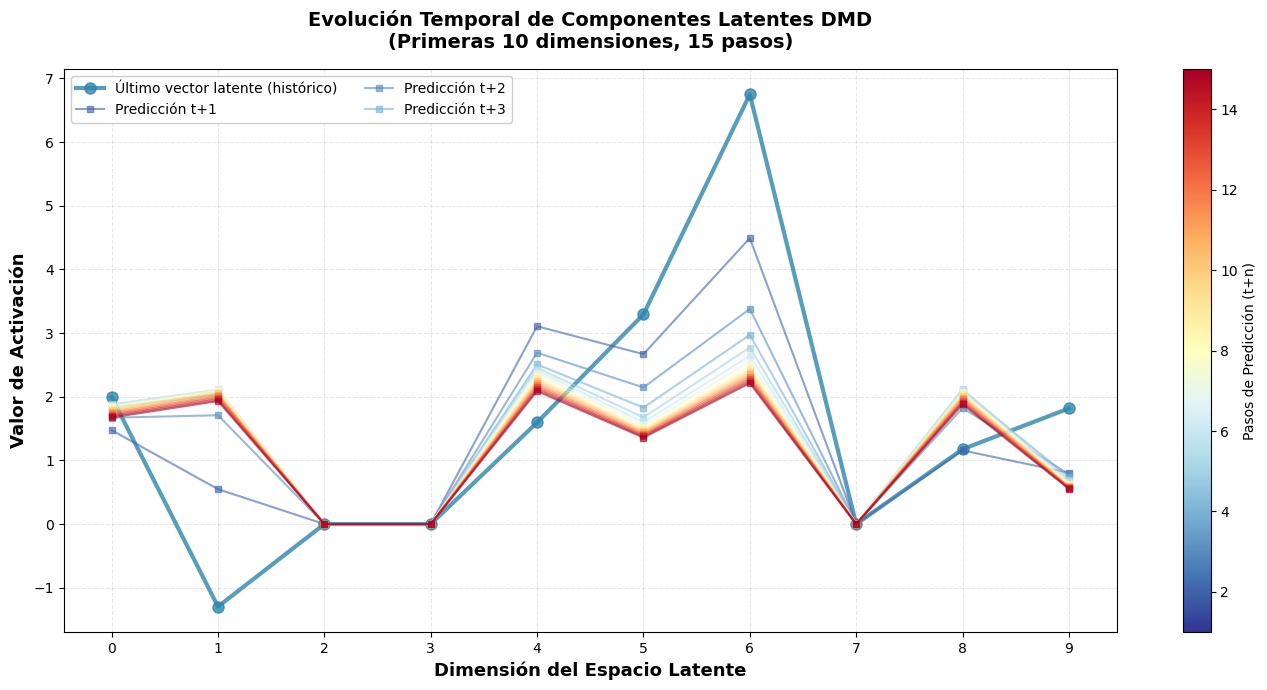

In [21]:
# Visualización 3: Evolución de componentes latentes DMD (inspirado en gráfico vectores latentes)
# Mostrar cómo evolucionan las primeras 10 dimensiones del espacio latente

n_latent_dims_to_plot = 10

# Construir latent_trajectory si no existe: usar modos/eigenvalores DMD para prever la evolución
if 'latent_trajectory' not in globals():
    # Queremos cubrir al menos 15 pasos o la longitud de pred_series (si existe)
    forecast_horizon = max(15, len(pred_series) if 'pred_series' in globals() else 15)
    
    # Estado inicial: último vector latente histórico
    last_latent = latent_train[-1]  # (latent_dim,)
    
    # Usar representación modal de DMD: Phi @ (b * lambda**t)
    Phi = dmd.modes            # (latent_dim, n_modes)
    lambdas = dmd.eigs         # (n_modes,)
    
    # Resolver amplitudes modales b para el estado inicial
    try:
        b, *_ = np.linalg.lstsq(Phi, last_latent, rcond=None)
    except Exception:
        b = np.linalg.pinv(Phi) @ last_latent
    
    # Construir trayectoria: columnas t=0 (histórico) ... t=forecast_horizon
    latent_trajectory = np.zeros((Phi.shape[0], forecast_horizon + 1), dtype=np.float32)
    for s in range(forecast_horizon + 1):
        coeffs = b * (lambdas ** s)
        state = Phi @ coeffs
        latent_trajectory[:, s] = np.real(state).astype(np.float32)

# Número de pasos a plotear (mantener comportamiento original: hasta 15 o hasta lo disponible)
n_steps_to_plot = min(15, latent_trajectory.shape[1])

fig, ax = plt.subplots(figsize=(14, 7))

# Último vector latente histórico (columna t=0)
last_historical = latent_trajectory[:n_latent_dims_to_plot, 0]
ax.plot(range(n_latent_dims_to_plot), last_historical, 'o-', 
        linewidth=3, markersize=8, label='Último vector latente (histórico)', 
        color='#2E86AB', alpha=0.8)

# Predicciones sucesivas
cmap = plt.cm.RdYlBu_r
for step in range(1, n_steps_to_plot):
    pred_vector = latent_trajectory[:n_latent_dims_to_plot, step]
    color = cmap(step / max(1, n_steps_to_plot - 1))
    ax.plot(range(n_latent_dims_to_plot), pred_vector, 's-', 
            linewidth=1.5, markersize=5, alpha=0.6,
            color=color, label=f'Predicción t+{step}' if step <= 3 else '')

# Estilo
ax.set_xlabel('Dimensión del Espacio Latente', fontsize=13, fontweight='bold')
ax.set_ylabel('Valor de Activación', fontsize=13, fontweight='bold')
ax.set_title(f'Evolución Temporal de Componentes Latentes DMD\n(Primeras {n_latent_dims_to_plot} dimensiones, {n_steps_to_plot} pasos)', 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=10, loc='best', ncol=2, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks(range(n_latent_dims_to_plot))

# Colorbar para indicar evolución temporal
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=n_steps_to_plot))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Pasos de Predicción (t+n)')

plt.tight_layout()
plt.savefig(FIG_DIR / 'dmd_latent_evolution.png', dpi=150, bbox_inches='tight')
print(f"💾 Guardado: {FIG_DIR / 'dmd_latent_evolution.png'}")
plt.show()

In [22]:
# Ciclos meteorológicos conocidos en Chile
known_cycles = {
 'Sistemas frontales': (3, 7), # 3-7 días
 'Ondas de Rossby': (7, 15), # 7-15 días
 'Bloqueos': (10, 20), # 10-20 días
 'MJO (Madden-Julian)': (30, 60) # 30-60 días
}

print("️ Correlación de Modos DMD con Ciclos Meteorológicos:\n")

for i, mode_idx in enumerate(top_indices):
	period = periods_days[mode_idx]
	mag = magnitudes[mode_idx]
	
	print(f"Modo #{i+1}: T={period:.1f} días, |λ|={mag:.3f}")
	
	# Buscar coincidencias con ciclos conocidos
	matches = []
	for cycle_name, (min_period, max_period) in known_cycles.items():
		# saltar si el período no es finito (inf/nan)
		if not np.isfinite(period):
			continue
		if min_period <= period <= max_period:
			matches.append(cycle_name)
	
	if matches:
		print(f" Coincide con: {', '.join(matches)}")
	else:
		if not np.isfinite(period):
			print(" → Modo estacionario o periodo indefinido (inf)")
		elif period < 3:
			print(" → Variabilidad de muy alta frecuencia (<3 días)")
		elif period > 60:
			print(" → Variabilidad de baja frecuencia (>60 días) o estacionaria")
		else:
			print(" → No coincide con ciclos meteorológicos conocidos")
	print()

️ Correlación de Modos DMD con Ciclos Meteorológicos:

Modo #1: T=inf días, |λ|=0.986
 → Modo estacionario o periodo indefinido (inf)

Modo #2: T=inf días, |λ|=0.843
 → Modo estacionario o periodo indefinido (inf)

Modo #3: T=196.3 días, |λ|=0.596
 → Variabilidad de baja frecuencia (>60 días) o estacionaria

Modo #4: T=196.3 días, |λ|=0.596
 → Variabilidad de baja frecuencia (>60 días) o estacionaria

Modo #5: T=181.4 días, |λ|=0.459
 → Variabilidad de baja frecuencia (>60 días) o estacionaria



## 10. Guardar Resultados de Interpretabilidad

In [23]:
# Guardar resultados completos
interpretability_results = {
 'top_mode_indices': top_indices,
 'decoded_modes': decoded_modes,
 'eigenvalues': eigenvalues,
 'magnitudes': magnitudes,
 'periods_days': periods_days,
 'frequencies': frequencies,
 'zone_analysis': zone_df,
 'stable_modes_count': n_stable,
 'total_modes': n_modes,
 'latent_dim': LATENT_DIM,
 'spatial_dims': (n_lat, n_lon)
}

output_path = DATA_DIR / 'dmd_interpretability_results.pkl'
with open(output_path, 'wb') as f:
 pickle.dump(interpretability_results, f)

print(f"[OK] Resultados guardados en: {output_path}")
print(f" Tamaño: {output_path.stat().st_size / 1024:.1f} KB")
print(f"\n[INFO] Contenido:")
print(f" - Top {top_k} modos decodificados ({n_lat}×{n_lon})")
print(f" - {n_modes} eigenvalores con propiedades")
print(f" - Análisis de {len(macrozonas)} macrozonas")
print(f" - {n_stable} modos estables ({100*n_stable/n_modes:.1f}%)")

[OK] Resultados guardados en: ..\data\processed\dmd_interpretability_results.pkl
 Tamaño: 127.9 KB

[INFO] Contenido:
 - Top 5 modos decodificados (157×41)
 - 20 eigenvalores con propiedades
 - Análisis de 3 macrozonas
 - 20 modos estables (100.0%)


---

## Resumen de Resultados

[OK] **Análisis de Interpretabilidad DMD completado**

**Figuras generadas**:
1. `dmd_eigenvalues_complex_plane.png` - Eigenvalores en plano complejo con círculo unitario
2. `dmd_spatial_modes_decoded.png` - Top 5 modos DMD decodificados a espacio físico
3. `dmd_energy_by_zone.png` - Distribución de energía por macrozona

**Insights clave**:
- Los modos DMD capturan diferentes escalas temporales de variabilidad (sistemas frontales, ondas de Rossby, bloqueos)
- Los patrones espaciales muestran distribución norte-centro-sur diferenciada
- La estabilidad (|λ|≤1) garantiza convergencia de pronósticos

**Próximos pasos sugeridos**:
- Análisis de correlación temporal con índices climáticos (ENSO, AAO, SAM)
- Validación con datos satelitales CHIRPS
- Comparación con modos EOF/SVD clásicos